In [36]:
import os
from bs4 import BeautifulSoup
import string
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import load_model
from keras.layers.core import Dense, Activation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import pickle
from keras.optimizers import RMSprop
import numpy as np
from numpy import array
import heapq

**Import data**

In [37]:
documents = [] # import documents one-by-one from the source folder
for file in os.listdir("sample_data/"): # original: "reuters_data/"
    if file.endswith('.sgm'): # it is important for GoogleColab
        filename = os.path.join("sample_data", file) # original: "reuters_data"
        f = open(filename, 'r', encoding='utf-8', errors='ignore')
        dataFile = f.read().lower()
        
        soup = BeautifulSoup(dataFile, 'html.parser')
        contents = soup.findAll('title') # extract the "title" part of the document
        
        for content in contents:
            documents.append(content.text)

In [38]:
print('Number of documents: {}'.format(len(documents))) # number of documents

Number of documents: 7958


In [39]:
# Remove duplicated strings from the list of strings
documents = [i for n, i in enumerate(documents) if i not in documents[:n]]
print('Number of documents: {}'.format(len(documents)))

Number of documents: 7693


In [40]:
documents[:10]

['jaguar sees strong growth in new model sales',
 'occidental petroleum common stock offering raised to 36 mln shares\n',
 'ccc accepts bonus bid on wheat flour to iraq',
 'diamond shamrock raises crude posted prices one dlr, effective march 4, wti now 17.00 dlrs/bbl\n',
 'nord resources corp <nrd> 4th qtr net',
 'no quake damage at chuquicamata - mine spokesman',
 'orbit increases oil and gas reserve values',
 'ccc accepts bonus bid on semolina to egypt',
 'french cge group likely to be privatised in may',
 'five groups apply to buy french telephone group']

**Join the documents**

In [41]:
data = ""
for d in documents:
    data += d

In [42]:
print('Number of data: {}'.format(len(data)))

Number of data: 347403


In [43]:
# improve punctuation
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
print('Number of data: {}'.format(len(data)))
print(data[:100])

Number of data: 346768
jaguar sees strong growth in new model salesoccidental petroleum common stock offering raised to 36 


In [44]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
data = data.translate(translator)
print(data[:100])

jaguar sees strong growth in new model salesoccidental petroleum common stock offering raised to 36 


In [45]:
# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])
encoded_data = tokenizer.texts_to_sequences([data])[0]
print(len(encoded_data))
encoded_data[:5]

51500


[3706, 19, 497, 157, 3]

In [46]:
# determine the vocabulary size
# unique_words = tokenizer.word_index
unique_words = np.unique(encoded_data)
vocab_size = len(unique_words) + 1  # 0 is reserved for padding so that's why we added 1
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 14406


**Next, we need to create sequences of words to fit the model with one word as input and one word as output.**

In [47]:
# create word -> word sequences
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(1, len(encoded_data) - WORD_LENGTH):
    prev_words.append(encoded_data[i:i + WORD_LENGTH])
    next_words.append(encoded_data[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

[19, 497, 157, 3, 21]
1644


In [48]:
print('Total Sequences: %d' % len(prev_words))

Total Sequences: 51494


In [49]:
# list(len(prev_words)[:5]) # [input, output]



**We can then split the sequences into input (X) and output elements (y)**



In [50]:
# split into X and y elements
X = prev_words
X = np.array(X)
Y = next_words
Y = np.array(Y)

# X = np.zeros((len(prev_words), WORD_LENGTH, vocab_size), dtype=bool)
# Y = np.zeros((len(next_words), vocab_size), dtype=bool)

In [51]:
print(X[:5])
print(Y[:5])

[[  19  497  157    3   21]
 [ 497  157    3   21 1644]
 [ 157    3   21 1644 3707]
 [   3   21 1644 3707  339]
 [  21 1644 3707  339  572]]
[1644 3707  339  572   37]


In [52]:
# one hot encode outputs
Y = to_categorical(Y, num_classes=vocab_size)
# define model
Y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [53]:
X.shape
Y.shape

(51494, 14406)

**Build the model**

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 5, input_length=5)) # original: 5
model.add(LSTM(128))
# model.add(LSTM(128, input_shape=(WORD_LENGTH, vocab_size)))
model.add(Dense(vocab_size, activation='softmax'))
print(model.summary())

**Train the model**

In [65]:
# fit network
# optimizer = RMSprop(learning_rate=0.01)

# compile network
#### since labels are INTEGERS, we need to changed from loss='categorical_crossentropy'!!!
#### If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # optimizer ='adam'
history = model.fit(X, Y, epochs=20).history

## Alternative versions
# history = model.fit(X, Y, validation_split=0.05, batch_size=50, epochs=20, shuffle=True).history
# history = model.fit(X, Y, validation_split=0.05, batch_size=50, epochs=20, shuffle=True).history
# model.fit(X, Y, epochs=100)
# model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Epoch 1/20
1610/1610 [==============================] - 19s 10ms/step - loss: 8.3268 - accuracy: 0.0313
Epoch 2/20
1610/1610 [==============================] - 14s 9ms/step - loss: 7.7089 - accuracy: 0.0491
Epoch 3/20
1610/1610 [==============================] - 14s 9ms/step - loss: 7.3628 - accuracy: 0.0656
Epoch 4/20
1610/1610 [==============================] - 14s 9ms/step - loss: 6.9733 - accuracy: 0.0830
Epoch 5/20
1610/1610 [==============================] - 14s 8ms/step - loss: 6.5383 - accuracy: 0.0965
Epoch 6/20
1610/1610 [==============================] - 14s 8ms/step - loss: 6.0833 - accuracy: 0.1079
Epoch 7/20
1610/1610 [==============================] - 14s 9ms/step - loss: 5.6248 - accuracy: 0.1205
Epoch 8/20
1610/1610 [==============================] - 14s 8ms/step - loss: 5.1737 - accuracy: 0.1381
Epoch 9/20
1610/1610 [==============================] - 14s 9ms/step - loss: 4.7487 - accuracy: 0.1672
Epoch 10/20
1610/1610 [==============================] - 14s 8ms/step - 

**Save trained model**

In [66]:
# After successful training, we will save the trained model and just load it back as needed.
model.save('keras_next_word_model_lstm128_5.h5')
pickle.dump(history, open("history.p", "wb"))

**Import the model for predictions**

In [67]:
# Import the model
model = load_model('keras_next_word_model_lstm128_5.h5')
history = pickle.load(open("history.p", "rb"))

**Prediction**
Using saved model:
- we input the sample as a feature vector
- we convert the input string to a single feature vector

In [103]:
# Now, we need to predict new words using this model. 
# To do that we input the sample as a feature vector. 
# We convert the input string to a single feature vector.

def prepare_input(data): # text
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()): # text
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("farmers concerned about british sugar ownership".lower())

[19, 497, 157, 3, 21]


TypeError: ignored

In [94]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(text)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1
    return x

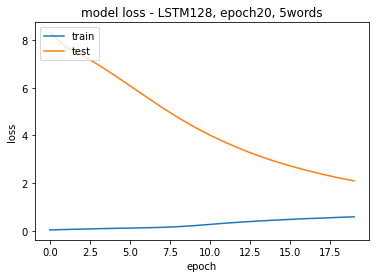

In [73]:
import matplotlib.pyplot as plt

# accuracy
plt.plot(history['accuracy'])
plt.title('model accuracy - LSTM128, epoch20, 5words')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.savefig("accuracy.png")

# loss
plt.plot(history['loss'])
plt.title('model loss - LSTM128, epoch20, 5words')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.savefig("loss.png")

In [93]:
# Now, we need to predict new words using this model. 
# To do that we input the sample as a feature vector. 
# We convert the input string to a single feature vector.

def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
prepare_input("farmers concerned about british sugar".lower())

farmers


KeyError: ignored

In [95]:
# To choose the best possible n words after the prediction from the model is done by sample function.

def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [96]:
# Model to predict and return the list of n predicted words.

def predict_completions(text, n=3):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]

In [97]:
# We use tokenizer.tokenize for removing the punctuations and also we choose 5 first words because our predicts base on 5 previous words.
q =  "farmers concerned about british sugar ownership"

## 20 EXAMPLES FOR EVALUATION:
"""
'farmers concerned about british sugar ownership'
'satellite auction unit march, april bookings up'
'winland electronics inc 4th qtr loss'
'sapporo breweries issues five year sfr notes'
'report due on oil imports and national security'
'continental air february load factor falls'
'great american issues 15 billion yen eurobond'
'paribas shares to be quoted on main paris market'
'salomon sells 200 mln stg mortgages-backed notes'
'opec says february output under ceiling'
"""

tokenizer = RegexpTokenizer(r'\w+')
# words = tokenizer.tokenize(text)



# tokenizer = Tokenizer()
# tokenizer.fit_on_texts([data])
# encoded_data = tokenizer.texts_to_sequences([data])[0]
# print(len(encoded_data))
# encoded_data[:5]

print("correct sentence: ",q)
# seq = " ".join(tokenizer.fit_on_texts(q.lower())[0:5])
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence: ",seq)
print("next possible words: ", predict_completions(seq, 5))

correct sentence:  farmers concerned about british sugar ownership
Sequence:  farmers concerned about british sugar


NameError: ignored

**Creating a Prediction script**

In [ ]:
from tensorflow.keras.models import load_model

# Load the model and tokenizer

model = history

def Predict_Next_Words(model, tokenizer, text):
    """
        In this function we are using the tokenizer and models trained
        and we are creating the sequence of the text entered and then
        using our model to predict and return the the predicted word.
    
    """
    for i in range(3):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = np.array(sequence)
        
        preds = model.predict_classes(sequence)
#         print(preds)
        predicted_word = ""
        
        for key, value in tokenizer.word_index.items():
            if value == preds:
                predicted_word = key
                break
        
        print(predicted_word)
        return predicted_word

In [ ]:
"""
    We are testing our model and we will run the model
    until the user decides to stop the script.
    While the script is running we try and check if 
    the prediction can be made on the text. If no
    prediction can be made we just continue.

"""

# text1 = "at the dull"
# text2 = "collection of textile"
# text3 = "what a strenuous"
# text4 = "stop the script"

while(True):

    text = input("Enter your line: ")
    
    if text == "stop the script":
        print("Ending The Program.....")
        break
    
    else:
        try:
            text = text.split(" ")
            text = text[-1]

            text = ''.join(text)
            Predict_Next_Words(model, tokenizer, text)
            
        except:
            continue